Importing the required packages

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from IPython.core.debugger import set_trace
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from torch.autograd import Variable
# we need google drive access to upload the datasets
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initial settings


In [ ]:
kwargs={}
class Args():
  def __init__(self):
      self.batch_size = 64
      self.test_batch_size = 64
      self.epochs = 10
      self.lr = 0.01
      self.momentum = 0.9
      self.seed = 1
      self.log_interval = int(10000 / self.batch_size)
      self.cuda = False

args = Args()

use_cuda = torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

MNIST Clasification using a convolutional neural network

In [ ]:
no_filters1 = 20
no_filter2 = 50
no_neurons1 = 500
class CNN(nn.Module):
    # the init() is called a single time, when you create the model
    # so all the layers should be created here.
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = no_filters1, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
        self.fc1 = nn.Linear(in_features = 4 * 4 * no_filter2, out_features = no_neurons1)
        self.fc2 = nn.Linear(in_features = no_neurons1, out_features = 10)
    # the forward() is called at each iteration, so we only apply the already
    # created operations inside this function 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*no_filter2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Importing the MNIST dataset

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-04-01 16:31:42--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-01 16:31:42--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [        <=>         ]  33.20M  6.87MB/s    in 14s     

2021-04-01 16:31:57 (2.41 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

Creating the necessary data loader

Labels of the shown images: tensor([6, 1, 4, 0, 7])


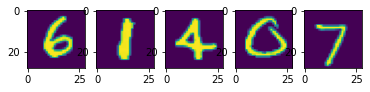

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.ToPILImage(), 
                      transforms.RandomHorizontalFlip()
                   ])),
    batch_size=args.batch_size, shuffle=True,drop_last=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.test_batch_size, shuffle=False,drop_last=True, **kwargs)

first_train_batch_imgs, first_train_batch_labels = next(iter(train_loader))

f, axarr = pyplot.subplots(1,5)
for i in range(5):
  axarr[i].imshow(first_train_batch_imgs[i,0])
print(f'Labels of the shown images: {first_train_batch_labels[:5]}')

Defining two functions: one for training, one for testing

In [ ]:
def traintest(args, model, device, train_loader, optimizer, epoch):
    model.train()
    all_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        all_losses.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        num_iter = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target) 
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).float().mean().item()
            num_iter += 1
    test_loss /= num_iter
    test_accuracy = 100. * correct / num_iter
    print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        test_loss,
        test_accuracy))
    return np.array(all_losses).mean(), test_loss, test_accuracy

Training the model

In [ ]:
def plot_loss(loss, label, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.legend()

model = CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

losses_train = []
losses_test = []
accuracy_test = []
for epoch in range(1, args.epochs):
    train_loss, test_loss, test_accuracy = traintest(args, model, device, test_loader)
    losses_train.append(train_loss)
    losses_test.append(test_loss)
    accuracy_test.append(test_accuracy)

pyplot.figure(1)
plot_loss(losses_train,'train_loss','red')
plot_loss(losses_test,'test_loss')
pyplot.figure(2)
plot_loss(accuracy_test,'test_accuracy')

torch.save(model.state_dict(),"mnist_cnn.pt")


NameError: ignored

Importing the new dataset and tranforming it into a pytorch friendly format.
Because we want to test the second model using 20%, 50% and then 100% of our dataset, we will create multiple dataloaders.

np_dataset_large shape: (5000, 1, 100, 100)
2.0
2.0
1.0
1.0
3.0
np_dataset_large shape: (1000, 1, 100, 100)
1.0
5.0
4.0
5.0
2.0
np_dataset_large shape: (1000, 1, 100, 100)
2.0
2.0
1.0
1.0
3.0
np_dataset_large shape: (2500, 1, 100, 100)
2.0
2.0
1.0
1.0
3.0


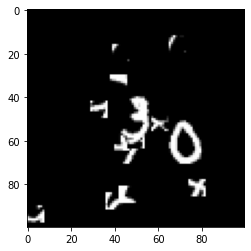

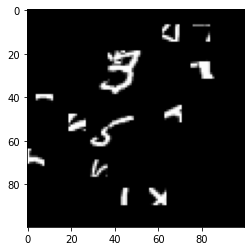

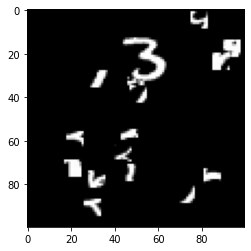

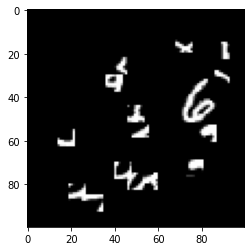

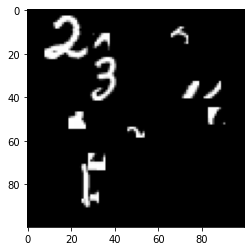

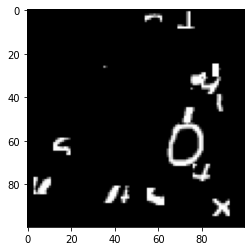

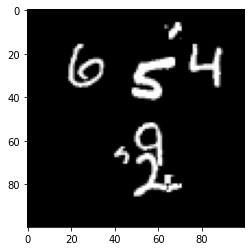

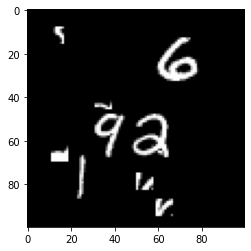

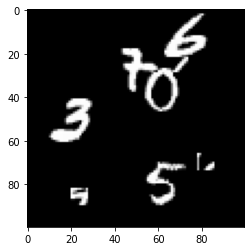

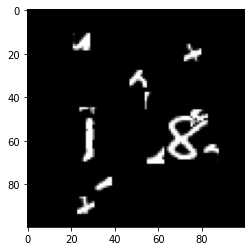

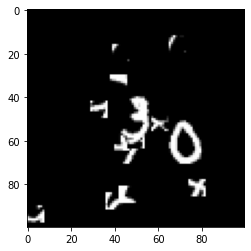

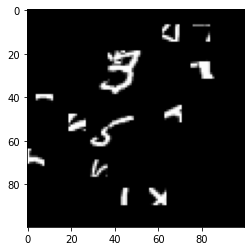

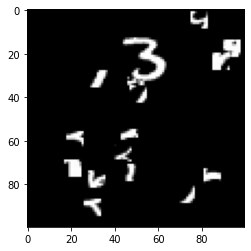

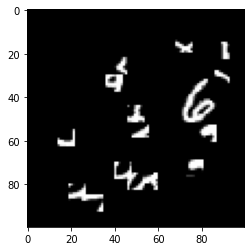

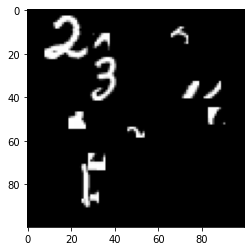

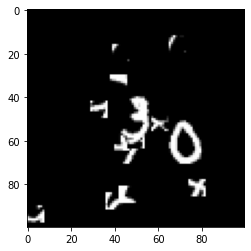

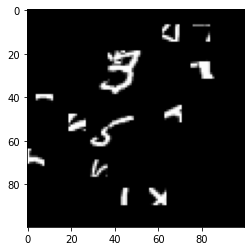

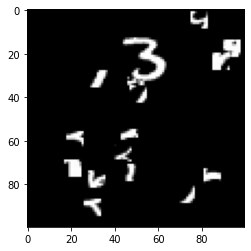

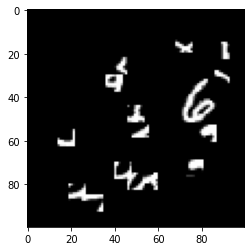

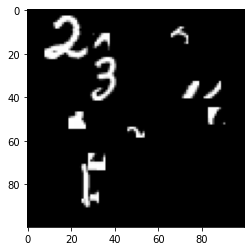

In [ ]:
import pickle

def get_large_dataset(path, max_batch_idx=100, shuffle=False,first_k=5000):
  with open(path,'rb') as handle:
    data = pickle.load(handle)
  np_dataset_large  = np.expand_dims(data['images'],1)[:first_k]
  np_dataset_no_count = data['no_count'].astype(np.float32)[:first_k]
  
  print(f'np_dataset_large shape: {np_dataset_large.shape}')
  for ii in range(5):
    example = np_dataset_large[10+ii].reshape((100, 100))
    pyplot.figure()
    pyplot.imshow(example, cmap="gray")
    print(np_dataset_no_count[10+ii])

  from torch.utils.data import TensorDataset
  from torch.utils.data import DataLoader
  dataset_large, dataset_no_count = map(torch.tensor, 
                (np_dataset_large, np_dataset_no_count))
  dataset_large = dataset_large.to(device)
  dataset_no_count = dataset_no_count.to(device)

  large_dataset = TensorDataset(dataset_large, dataset_no_count)
  large_data_loader = DataLoader(large_dataset, 
       batch_size=args.batch_size, shuffle=shuffle, drop_last=True)
  return large_data_loader

path_train = '/content/gdrive/MyDrive/mnist_count_train.pickle'
path_test = '/content/gdrive/MyDrive/mnist_count_test.pickle'

large_data_loader_train = get_large_dataset(path_train,max_batch_idx=50,shuffle=True)
large_data_loader_test = get_large_dataset(path_test,max_batch_idx=50)
large_data_loader_train2 = get_large_dataset(path_train,max_batch_idx=50,shuffle=True, first_k=1000)
large_data_loader_train5 = get_large_dataset(path_train,max_batch_idx=50,shuffle=True, first_k=2500)

Defining the fully convolutional neural network for the second model.

In [ ]:
class CNN_fully_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, no_filters1, 5, 1)
        self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
        self.fully_conv1  = nn.Conv2d(no_filter2,no_neurons1, 4)
        self.fully_conv2 = nn.Conv2d(no_neurons1,10, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.fully_conv1(x))
        x = self.fully_conv2(x)
        return F.log_softmax(x, dim=1)

We save the MNIST classification model to use it for later.

In [ ]:
def preprocess(data):
  return data.float() / 225.0
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

PATH = 'conv_net.pt'
torch.save(model.state_dict(), PATH)

model_fuly_conv = CNN_fully_conv()

loaded_state_dict = torch.load(PATH)

model_dict = {}
for key,val in loaded_state_dict.items():
  key = key.replace('fc','fully_conv')
  print(f'key: {key}')
  if 'fully_conv1.weight' in key:
    val = val.view(-1,no_filter2,4,4)
  if 'fully_conv2.weigh' in key:
    val = val.view(-1,no_neurons1,1,1)
  model_dict[key] = val
  
model_fuly_conv.load_state_dict(model_dict)
model_fuly_conv = model_fuly_conv.to(device)

print(model_fuly_conv.parameters)


Model's state_dict:
conv1.weight 	 torch.Size([20, 1, 5, 5])
conv1.bias 	 torch.Size([20])
conv2.weight 	 torch.Size([50, 20, 5, 5])
conv2.bias 	 torch.Size([50])
fc1.weight 	 torch.Size([500, 800])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])
key: conv1.weight
key: conv1.bias
key: conv2.weight
key: conv2.bias
key: fully_conv1.weight
key: fully_conv1.bias
key: fully_conv2.weight
key: fully_conv2.bias
<bound method Module.parameters of CNN_fully_conv(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fully_conv1): Conv2d(50, 500, kernel_size=(4, 4), stride=(1, 1))
  (fully_conv2): Conv2d(500, 10, kernel_size=(1, 1), stride=(1, 1))
)>


Because our model returns the probability for the center of a digit to be at a certain position, and we have a maximum of 5 digits in an image, we will initially pick the first 5 indexes, and choose the ones that pass the threshold. The resulting number will be our prediction.
Since the output has very low values, we will use the exponential function to get some more resonable values.
The threshold was chosen after repeated trials, keeping in mind the predictions and the dataset.
At last, we will be plotting some figures and their respective characteristic maps.

large_imgs shape torch.Size([64, 1, 100, 100])
5 iterations
Accuracy: 17.1875
large_imgs shape torch.Size([64, 1, 100, 100])
5 iterations
Accuracy: 18.75
large_imgs shape torch.Size([64, 1, 100, 100])
5 iterations
Accuracy: 28.125
large_imgs shape torch.Size([64, 1, 100, 100])
5 iterations
Accuracy: 28.125
large_imgs shape torch.Size([64, 1, 100, 100])
5 iterations
Accuracy: 28.125
large_imgs shape torch.Size([64, 1, 100, 100])
5 iterations
Accuracy: 28.125
large_imgs shape torch.Size([64, 1, 100, 100])
5 iterations
Accuracy: 28.125
large_imgs shape torch.Size([64, 1, 100, 100])
5 iterations
Accuracy: 28.125
large_imgs shape torch.Size([64, 1, 100, 100])
5 iterations
Accuracy: 28.125
large_imgs shape torch.Size([64, 1, 100, 100])
5 iterations
Accuracy: 28.125
large_imgs shape torch.Size([64, 1, 100, 100])
5 iterations
Accuracy: 28.125
large_imgs shape torch.Size([64, 1, 100, 100])
5 iterations
Accuracy: 28.125
large_imgs shape torch.Size([64, 1, 100, 100])
5 iterations
Accuracy: 28.125

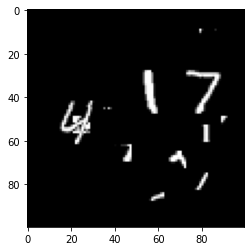

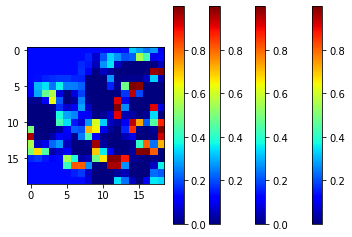

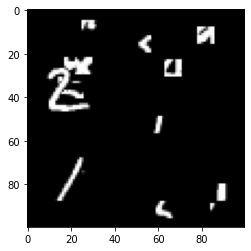

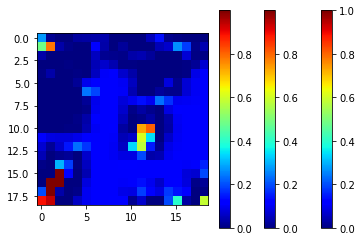

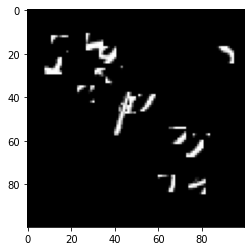

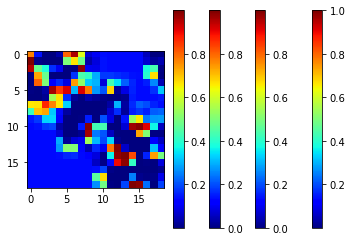

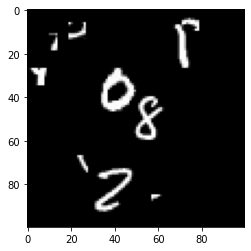

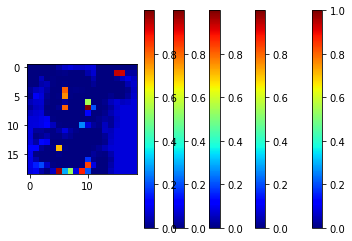

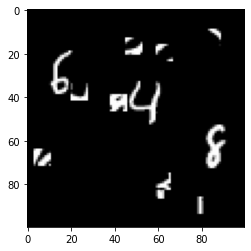

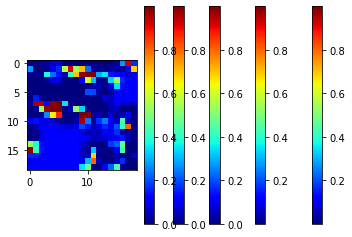

In [ ]:
threshold = 0.998998
accuracy = 0
for batch_idx, (large_imgs, target_coords) in enumerate(large_data_loader_test):
  print(f'large_imgs shape {large_imgs.shape}')
  acc = 0
  n = 0
  large_imgs = preprocess(large_imgs)
  out_prob_maps = torch.exp(model_fuly_conv(large_imgs))
  max_values, max_ind = torch.topk(torch.max(out_prob_maps.view(args.batch_size,10,-1),dim=2)[0],5,dim=1)
  count_net_output = (max_values[:, 0:5] > threshold).sum(dim=1).float()
  n = n + large_imgs.shape[0]
  acc = acc + torch.sum(target_coords == count_net_output)
  if batch_idx == 0:
    for ii in range(5):
      pyplot.figure()
      pyplot.imshow(large_imgs[ii,0].cpu().detach().numpy(), cmap="gray")

      pyplot.figure()
      for j in range(5):
        if max_values[ii, j] >= threshold:
          pyplot.imshow(out_prob_maps[ii,max_ind[ii, j]].cpu().detach().numpy(), cmap="jet")
          pyplot.colorbar()
     
  
  if 100 / n * acc.float() > accuracy:
    accuracy = 100 / n * acc.float()
    
  print(f'{i+1} iterations\nAccuracy: {accuracy}')

METODA 2


For the second method, we will directly predict the number of digits in every image. 

Initially, we define our model with 2 convolutial layers. After repeated tries we deducted that this is the best scheme.

We used the ReLU activation function because our predictions should be numbers between 1 and 5. 

In [ ]:
class CNN_count(nn.Module):
  def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, no_filters1, 5, 1)
      self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
      self.fully_conv1  = nn.Conv2d(no_filter2,no_neurons1, 4)
      self.fully_conv2_new = nn.Conv2d(no_neurons1,5, 1)
      self.linear_loc = nn.Linear(19*19*5,1)

  def forward(self, xb):
      x = xb.view(-1, 1, xb.shape[2], xb.shape[3])
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.fully_conv1(x))
      self.conv_act = self.fully_conv2_new(x).view(args.batch_size,-1)
      self.lin = self.linear_loc(self.conv_act)
      self.relu = F.relu(self.lin)
      return self.relu

We define 2 functions, for training and testing, which returns the error and accuracy for each epoch.
The mean squared loss function was used because it's the best performing one in a regression problem.


In [ ]:
criterion = nn.MSELoss()
def plot_loss(loss, label, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.legend()

def train_count(args, model, device, train_loader, optimizer, epoch):
    model.train()
    all_losses = []
    num_iter = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = preprocess(data)
        optimizer.zero_grad()
        output = model(data).view(-1)
        loss = criterion(output, target)
        loss.backward()
        all_losses.append(loss.data.cpu().numpy())
        optimizer.step()
        correct += output.round().eq(target).float().mean().item()
        num_iter += 1
        train_accuracy = 100. * correct / num_iter
        
        if False and batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.array(all_losses).mean(), train_accuracy

def test_count(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        num_iter = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = preprocess(data)
            output = model(data).view(-1)
            test_loss += F.mse_loss(output, target).item()
            correct += output.round().eq(target).float().mean().item()
            num_iter += 1
            test_accuracy = 100. * correct / num_iter
    test_loss /= num_iter

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
    return test_loss, test_accuracy

We first train the model as usual, with the initial random layers, and after that we use some layers that were pre-trained on the initial MNIST classifiyng model.

We chose the Adam optimizer because it's best performing on noisy data.

In the end, we will present the errors in a graph

key: conv1.weight
key: conv1.bias
key: conv2.weight
key: conv2.bias
key: fully_conv1.weight
key: fully_conv1.bias
key: fully_conv2.weight
key: fully_conv2.bias
Scratch epoch: 1

Test set: Average loss: 1.4906

Scratch epoch: 2

Test set: Average loss: 0.7535

Scratch epoch: 3

Test set: Average loss: 0.5886

Scratch epoch: 4

Test set: Average loss: 0.3874

Scratch epoch: 5

Test set: Average loss: 0.1793

Scratch epoch: 6

Test set: Average loss: 0.2478

Scratch epoch: 7

Test set: Average loss: 0.2004

Scratch epoch: 8

Test set: Average loss: 0.1725

Scratch epoch: 9

Test set: Average loss: 0.1331

Scratch epoch: 10

Test set: Average loss: 0.1259

Scratch epoch: 11

Test set: Average loss: 0.1236

Scratch epoch: 12

Test set: Average loss: 0.1330

Scratch epoch: 13

Test set: Average loss: 0.1566

Scratch epoch: 14

Test set: Average loss: 0.1186

Scratch epoch: 15

Test set: Average loss: 0.1177

Scratch epoch: 16

Test set: Average loss: 0.1353

Scratch epoch: 17

Test set: Aver

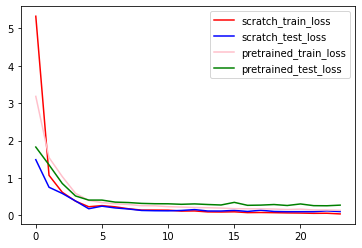

In [ ]:
PATH = 'conv_net.pt'
torch.save(model.state_dict(), PATH)

loc_model_scratch = CNN_count()
loc_model_pretrained = CNN_count()

loaded_state_dict = torch.load(PATH)
model_dict = {}
for key,val in loaded_state_dict.items():
  key = key.replace('fc','fully_conv')
  print(f'key: {key}')
  if 'fully_conv1.weight' in key:
    val = val.view(-1,no_filter2,4,4)
  if 'fully_conv2.weigh' in key:
    val = val.view(-1,no_neurons1,1,1)
  model_dict[key] = val

loc_model_scratch = loc_model_scratch.to(device)
loc_model_pretrained.load_state_dict(model_dict, strict=False)
loc_model_pretrained = loc_model_pretrained.to(device)

loc_model_pretrained.linear_loc.weight.data

optimizer_loc_scratch = optim.Adam(
    loc_model_scratch.parameters(), lr=0.0015)

optimizer_loc_pretrained = optim.Adam(
    loc_model_pretrained.parameters(), lr=0.00009)

losses_train = []
losses_test = []
accuracy_train = []
accuracy_test = []

for epoch in range(1, args.epochs + 15):
  
    print(f'Scratch epoch: {epoch}')
    train_loss, train_accuracy = train_count(args, loc_model_scratch, device, large_data_loader_train, optimizer_loc_scratch, epoch)
    test_loss, test_accuracy  = test_count(args, loc_model_scratch, device, large_data_loader_test)
    
    losses_train.append(train_loss)
    losses_test.append(test_loss)
    accuracy_train.append(train_accuracy)
    accuracy_test.append(test_accuracy)

losses_train_pre = []
losses_test_pre = []
accuracy_train_pre = []
accuracy_test_pre = []

for epoch in range(1, args.epochs + 15):
    print(f'Pretrained epoch: {epoch}')
    train_loss, train_accuracy = train_count(args, loc_model_pretrained, device, large_data_loader_train, optimizer_loc_pretrained, epoch)
    test_loss, test_accuracy  = test_count(args, loc_model_pretrained, device, large_data_loader_test)
    
    losses_train_pre.append(train_loss)
    losses_test_pre.append(test_loss)
    accuracy_train_pre.append(train_accuracy)
    accuracy_test_pre.append(test_accuracy)

plot_loss(losses_train,'scratch_train_loss','red')
plot_loss(losses_test,'scratch_test_loss')

plot_loss(losses_train_pre,'pretrained_train_loss','pink')
plot_loss(losses_test_pre,'pretrained_test_loss','green')

Accuray on training and testing, for both models.

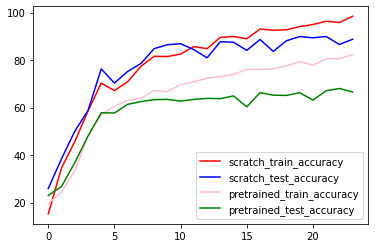

In [ ]:
plot_loss(accuracy_train,'scratch_train_accuracy','red')
plot_loss(accuracy_test,'scratch_test_accuracy')

plot_loss(accuracy_train_pre,'pretrained_train_accuracy','pink')
plot_loss(accuracy_test_pre,'pretrained_test_accuracy','green')

Final accuracy for both of our models.

In [ ]:
print(accuracy_train[-1])
print(accuracy_test[-1])
print(accuracy_train_pre[-1])
print(accuracy_test_pre[-1])

98.4375
88.75
82.29166666666667
66.5625


Training and testing the models with only 20% of the training dataset.

In [ ]:
accuracy_train2 = []
accuracy_test2 = []

for epoch in range(1, args.epochs + 15):
  
    print(f'Scratch epoch: {epoch}')
    _, train_accuracy = train_localisation(args, loc_model_scratch, device, large_data_loader_train2, optimizer_loc_scratch, epoch)
    _, test_accuracy  = test_localisation(args, loc_model_scratch, device, large_data_loader_test)
    
    accuracy_train2.append(train_accuracy)
    accuracy_test2.append(test_accuracy)

accuracy_train_pre2 = []
accuracy_test_pre2 = []

for epoch in range(1, args.epochs + 15):
    print(f'Pretrained epoch: {epoch}')
    _, train_accuracy = train_localisation(args, loc_model_pretrained, device, large_data_loader_train2, optimizer_loc_pretrained, epoch)
    _, test_accuracy  = test_localisation(args, loc_model_pretrained, device, large_data_loader_test)

    accuracy_train_pre2.append(train_accuracy)
    accuracy_test_pre2.append(test_accuracy)


Scratch epoch: 1

Test set: Average loss: 0.1020

Scratch epoch: 2

Test set: Average loss: 0.1068

Scratch epoch: 3

Test set: Average loss: 0.1027

Scratch epoch: 4

Test set: Average loss: 0.1052

Scratch epoch: 5

Test set: Average loss: 0.1091

Scratch epoch: 6

Test set: Average loss: 0.1062

Scratch epoch: 7

Test set: Average loss: 0.1130

Scratch epoch: 8

Test set: Average loss: 0.1072

Scratch epoch: 9

Test set: Average loss: 0.1096

Scratch epoch: 10

Test set: Average loss: 0.1126

Scratch epoch: 11

Test set: Average loss: 0.1093

Scratch epoch: 12

Test set: Average loss: 0.1096

Scratch epoch: 13

Test set: Average loss: 0.1111

Scratch epoch: 14

Test set: Average loss: 0.1097

Scratch epoch: 15

Test set: Average loss: 0.1106

Scratch epoch: 16

Test set: Average loss: 0.1109

Scratch epoch: 17

Test set: Average loss: 0.1104

Scratch epoch: 18

Test set: Average loss: 0.1103

Scratch epoch: 19

Test set: Average loss: 0.1102

Scratch epoch: 20

Test set: Average los

Training and testing the models with only 50% of the training dataset.

In [ ]:
accuracy_train5 = []
accuracy_test5 = []

for epoch in range(1, args.epochs + 15):
  
    print(f'Scratch epoch: {epoch}')
    _, train_accuracy = train_localisation(args, loc_model_scratch, device, large_data_loader_train5, optimizer_loc_scratch, epoch)
    _, test_accuracy  = test_localisation(args, loc_model_scratch, device, large_data_loader_test)
    
    accuracy_train5.append(train_accuracy)
    accuracy_test5.append(test_accuracy)

accuracy_train_pre5 = []
accuracy_test_pre5 = []

for epoch in range(1, args.epochs + 15):
    print(f'Pretrained epoch: {epoch}')
    _, train_accuracy = train_localisation(args, loc_model_pretrained, device, large_data_loader_train5, optimizer_loc_pretrained, epoch)
    _, test_accuracy  = test_localisation(args, loc_model_pretrained, device, large_data_loader_test)

    accuracy_train_pre5.append(train_accuracy)
    accuracy_test_pre5.append(test_accuracy)

Scratch epoch: 1

Test set: Average loss: 0.1056

Scratch epoch: 2

Test set: Average loss: 0.1119

Scratch epoch: 3

Test set: Average loss: 0.1107

Scratch epoch: 4

Test set: Average loss: 0.1139

Scratch epoch: 5

Test set: Average loss: 0.1158

Scratch epoch: 6

Test set: Average loss: 0.1165

Scratch epoch: 7

Test set: Average loss: 0.1184

Scratch epoch: 8

Test set: Average loss: 0.1185

Scratch epoch: 9

Test set: Average loss: 0.1186

Scratch epoch: 10

Test set: Average loss: 0.1183

Scratch epoch: 11

Test set: Average loss: 0.1179

Scratch epoch: 12

Test set: Average loss: 0.1197

Scratch epoch: 13

Test set: Average loss: 0.1191

Scratch epoch: 14

Test set: Average loss: 0.1190

Scratch epoch: 15

Test set: Average loss: 0.1174

Scratch epoch: 16

Test set: Average loss: 0.1180

Scratch epoch: 17

Test set: Average loss: 0.1179

Scratch epoch: 18

Test set: Average loss: 0.1185

Scratch epoch: 19

Test set: Average loss: 0.1188

Scratch epoch: 20

Test set: Average los

Final accuracy for all the models : Ox axis represents the percent of data on which our models were trained, and the Oy axis represents the final accuracy for every case.

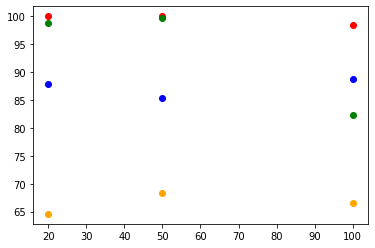

In [ ]:
plt.scatter(100, accuracy_train[-1], color='red')
plt.scatter(100, accuracy_test[-1],color='blue')
plt.scatter(100, accuracy_train_pre[-1],color='green')
plt.scatter(100, accuracy_test_pre[-1],color='orange')
plt.scatter(20, accuracy_train2[-1], color='red')
plt.scatter(20, accuracy_test2[-1],color='blue')
plt.scatter(20, accuracy_train_pre2[-1],color='green')
plt.scatter(20, accuracy_test_pre2[-1],color='orange')
plt.scatter(50, accuracy_train5[-1],color='red')
plt.scatter(50, accuracy_test5[-1],color='blue')
plt.scatter(50, accuracy_train_pre5[-1],color='green')
plt.scatter(50, accuracy_test_pre5[-1],color='orange')